### This notebook is based on the exercise 07 from the ML course at the EPFL. 
### See https://github.com/epfml/ML_course

In [353]:
from functools import partial
import math
import urllib
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn

### Data Creation
We will be approximating the following 2d function:
$$ f_{true}(x_1, x_2) = \cos\left(10 \sqrt{x_1^2+x_2^2}\right) \cdot \exp{\left(-4 (x_1^2+x_2^2)\right)} $$
over the rectangle $(x_1, x_2) \in [-1:1]\times[-1:1]$

We provide a function below that samples a grid of points and returns an $N \times 2$ tensor $X$. Fill in the other function that computes $Y=f_{true}(X)$ according to the formula above.

In [380]:
def sample_grid(N_sqrt=100):
    """
    Returns an Nx2 tensor of grid points in [-1:1]x[-1:1].
    N=N_sqrt*N_sqrt.
    """
    x1 = torch.linspace(-0.8, 0.8, N_sqrt)
    x1_grid, x2_grid = torch.meshgrid(x1, x1, indexing="xy")
    X = torch.stack((x1_grid, x2_grid), -1).view(-1, 2)
    return X


def compute_f_true(X):
    """
    Returns Y=f_true(X)
    X is an Nx2 vector, Y is an Nx1 vector
    """
    R = torch.sqrt((X**2).sum(dim=1))
    Y = torch.cos(10 * R) * torch.exp(-4 * R**2)
    return Y

### Model Definition
In this part we will create a simple model function for a ReLU fully connected network. We assume the model has 4 layers, an input dimension of 2, and output dimension of 1.
The inputs to the model are $X_0$ an $N \times 2$ matrix.
We use $K_{i}$ to denote the number of units in the $i$-th layer (i.e. their width or dimension, $i=1$ is the first layer). We assume the width of of the hidden layers (every layer except the last one) is constant, $K_i=K$. We set $K_0=2$ and $K_{L}=1$ corresponding to the number of input features and the dimension of the output.

Layer $i$ computes the following:
$$X_{i} = \phi(X_{i-1} W_{i} + b_{i})$$
Where $\phi=ReLU$ for all layers except the last one where it is identity, $W_{i}$ is a $K_{i-1} \times K_{i}$ matrix and $b_{i}$ is a bias vector with $K_{i}$ elements.

In [375]:
# Define the neural network
model = nn.Sequential(nn.Linear(2, 256),
                     nn.ReLU(),
                     nn.Linear(256, 256),
                     nn.ReLU(),
                     nn.Linear(256, 256),
                     nn.ReLU(),
                     nn.Linear(256, 1))

# Loss function : MSE
criterion = nn.MSELoss(reduction='sum')

### Training Loop
In this part we write a function that trains the model for a given number of steps.
We will use full-batch gradient descent with the [Adam optimizer](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) (using the PyTorch implementation).
The Adam optimizer performes a slightly modified version of gradient descent using a couple of tricks that make it more robust to hyperparameters than standard gradient descent (the link above has the algorithmic details).
Typically some hyperparameter tuning is still required, especially for the learning rate and weight decay (if used).
In this case the default hyperparameters should work quite well.

In [376]:
def train_network(num_steps, X, Y_true, lr = learning_rate, verbose=True):
    param = model.parameters()
    optimizer = torch.optim.Adam(param, lr)
    losses = []
    for step in range(num_steps):
        # Forward pass: compute predicted y by passing x to the model.
        Y = model(X)
        loss = torch.mean((Y.flatten() - Y_true.flatten()) ** 2)
        loss.backward()
        losses.append(loss.item())
        if verbose and step % 100 == 0:
            print(f"step={step} - loss={loss.item():0.5f}")
            
        if loss.item() < 1e-5 : break    
        optimizer.step()
        optimizer.zero_grad()

    if verbose:
        plt.plot(losses)
        plt.xlabel("Step")
        plt.ylabel("Loss")
        plt.grid()
        plt.show()

### Post-Processing Functions

In [387]:
def plot_heatmap(X, Y, N_sqrt, mark_level=None):
    x1_grid = X[:, 0].reshape((N_sqrt, N_sqrt))
    x2_grid = X[:, 1].reshape((N_sqrt, N_sqrt))
    plt.pcolormesh(x1_grid, x2_grid, Y.reshape_as(x1_grid), cmap = "RdBu_r", vmin=-1, vmax=1)
    plt.axis([x1_grid.min(), x1_grid.max(), x2_grid.min(), x2_grid.max()])
    plt.colorbar()
    if mark_level is None:
        mark_level = float(Y.mean())
    if isinstance(mark_level, (int, float)):
        plt.contour(
            x1_grid,
            x2_grid,
            Y.reshape_as(x1_grid),
            levels=[mark_level],
            colors="k",
            linewidths=1
        )
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")


def plot_cross_section(X, Y, value=0, **kwargs):
    x2 = X[:, 1]
    value_rounded = x2[torch.argmin(torch.abs(x2 - value))]
    mask = torch.isclose(X[:, 1], value_rounded)
    x1 = X[mask, 0]
    y = Y[mask]
    plt.plot(x1, y, **kwargs)
    
    
def plot_3d(X, Y, Y_true, N_sqrt):    
    x1_grid = X[:, 0].reshape((N_sqrt, N_sqrt))
    x2_grid = X[:, 1].reshape((N_sqrt, N_sqrt))
    # set up a figure twice as wide as it is tall
    fig = plt.figure(figsize=plt.figaspect(0.5))

    # =============
    # First subplot
    # =============
    # set up the Axes for the first plot
    ax = fig.add_subplot(1, 2, 1, projection='3d')

    # plot a 3D surface like in the example mplot3d/surface3d_demo

    ax.plot_surface(x1_grid, x2_grid, Y_true.reshape_as(x1_grid), cmap="RdBu_r",
                           linewidth=0, antialiased=False)
    ax.title.set_text('True')
    ax.set_xlabel('$x1$')
    ax.set_ylabel('x2')
    ax.set_zlabel('z')
    ax.view_init(30, -30)

    # ==============
    # Second subplot
    # ==============
    # set up the Axes for the second plot
    ax = fig.add_subplot(1, 2, 2, projection='3d')

    ax.plot_surface(x1_grid, x2_grid, Y_model.reshape_as(x1_grid),cmap="RdBu_r",linewidth=0, antialiased=False)
    ax.title.set_text('Model')
    ax.set_xlabel('$x1$')
    ax.set_ylabel('x2')
    ax.set_zlabel('z')
    ax.view_init(30, -30)
    plt.show()

### Train the network

step=0 - loss=0.07330
step=100 - loss=0.02565
step=200 - loss=0.00213
step=300 - loss=0.00016
step=400 - loss=0.00007
step=500 - loss=0.00021
step=600 - loss=0.00003
step=700 - loss=0.00300
step=800 - loss=0.00003
step=900 - loss=0.00002
step=1000 - loss=0.00310
step=1100 - loss=0.00002
step=1200 - loss=0.00002
step=1300 - loss=0.00001
step=1400 - loss=0.00002
step=1500 - loss=0.00001
step=1600 - loss=0.00022
step=1700 - loss=0.00001
step=1800 - loss=0.00001


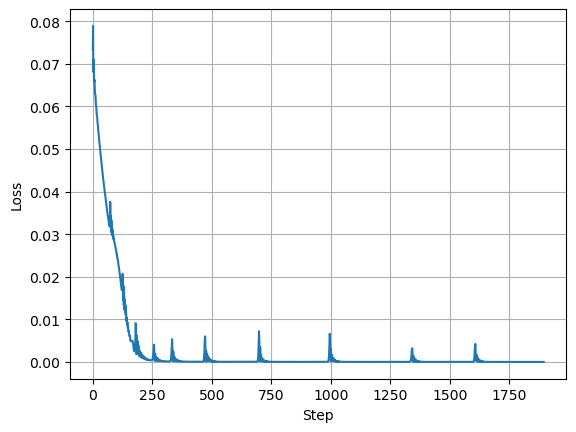

In [378]:
N_sqrt = 100

device = torch.device("cpu")
steps = 5000
lr = 1e-3

X = sample_grid(N_sqrt).to(device)
Y_true = compute_f_true(X).to(device)

# Train the model
train_network(steps,X, Y_true, lr)

# Compute the final model predictions
# Typically this would be on some sort of validation or test data
with torch.no_grad():
    Y_model = model(X)

### Data Visualisation

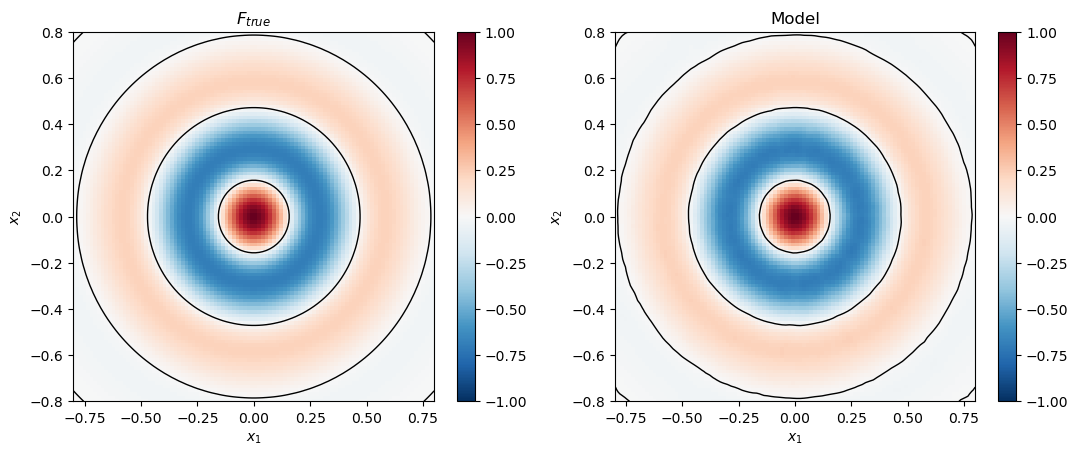

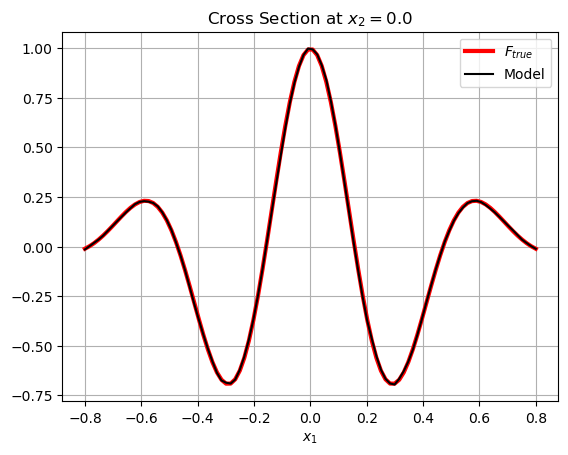

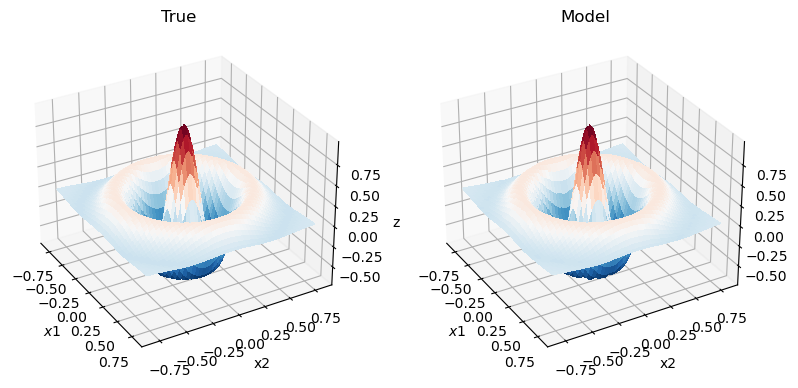

In [389]:
# Contour plot 
plt.figure(figsize=(2 * 6.4, 4.8))
plt.subplot(121)
plot_heatmap(X, Y_true, N_sqrt, 0.0)
plt.title("$F_{true}$")
plt.subplot(122)
plot_heatmap(X, Y_model, N_sqrt, 0.0)
plt.title("Model")
plt.show()

# Cross section plot
plt.figure()
x2_value = 0.0
plot_cross_section(X, Y_true, x2_value, label="$F_{true}$", color="r", linewidth=3)
plot_cross_section(X, Y_model, x2_value, label="Model", color="k", ls="-")
plt.xlabel("$x_1$")
plt.title(f"Cross Section at $x_2={x2_value}$")
plt.grid()
plt.legend()
plt.show()

# 3D plot
plot_3d(X, Y, Y_true, N_sqrt)
plt.show()